# Task 4: Classification Analysis

## Objective
Create binary classification models to distinguish between ischemic (Class 1) and non-ischemic (Class 0) cardiovascular conditions based on patient profiles.

### Label Definition
- **Class 1 (Ischemic)**: ICD codes I20, I21, I22, I24, I25
- **Class 0 (Non-ischemic)**: All other cardiovascular codes
- If a patient has multiple diagnoses and at least one is ischemic, label as Class 1

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set data directory (relative path, works on Windows and Unix)
# Notebook is in code/, data is in Data/ (one level up from code/)
# Get the current working directory (where notebook is executed from)
notebook_dir = Path.cwd()
# If we're in the code directory, go up one level to find Data/
if notebook_dir.name == 'code':
    DATA_DIR = notebook_dir.parent / 'Data'
else:
    # Assume we're in the project root, Data/ should be here
    DATA_DIR = notebook_dir / 'Data'

# Convert to string for compatibility with pandas read_csv
DATA_DIR = str(DATA_DIR.resolve())
plots_dir = (notebook_dir / '..' / 'plots').resolve()
FIG_DIR = (notebook_dir / '..' / 'plots').resolve()
print(f"Data directory: {DATA_DIR}")
print("Libraries imported successfully!")

Data directory: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\Data
Libraries imported successfully!


## 1. Load and Prepare Data

In [2]:
# Load heart diagnoses dataset
heart_diag = pd.read_csv(os.path.join(DATA_DIR, "heart_diagnoses_1.csv"))
print(f"Heart Diagnoses shape: {heart_diag.shape}")
print(f"\nColumns: {heart_diag.columns.tolist()}")
print(f"\nFirst few rows:")
heart_diag[['subject_id', 'hadm_id', 'icd_code']].head(10)

Heart Diagnoses shape: (4864, 25)

Columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint', 'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI', 'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age', 'anchor_year', 'dod']

First few rows:


,subject_id,hadm_id,icd_code
0,10000980,29654838,I50
1,10000980,26913865,I21
2,10002013,24760295,I21
3,10002155,23822395,I21
4,10004457,28723315,I35
5,10007058,22954658,I21
6,10010424,28388172,I25
7,10012343,27658045,I21
8,10013569,22891949,I50
9,10014651,20051301,I50


In [3]:
# Load patient profile
patient_profile = pd.read_csv(os.path.join(DATA_DIR, "patient_profile_broad_clean_classification.csv"))
# droopp age bc imputed with icd code information
if "age" in patient_profile.columns:
    patient_profile.drop(columns=["age"], inplace=True)
print(f"Patient Profile shape: {patient_profile.shape}")
print(f"\nColumns: {patient_profile.columns.tolist()}")
print(f"\nFirst few rows:")
patient_profile.head()

Patient Profile shape: (5166, 23)

Columns: ['subject_id', 'hadm_id', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'procedure_span_days_missing', 'gender_F', 'micro_resistance_score', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index', 'cardiac_comorbidity_score', 'has_hf', 'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs', 'total_procedures', 'total_microbio_events', 'unique_antibiotics', 'is_dead']

First few rows:


,subject_id,hadm_id,abnormal_ratio,qc_fail_ratio,fluid_diversity,procedure_span_days_missing,gender_F,micro_resistance_score,metabolic_stress_index,oxygenation_dysfunction_index,...,cardiac_comorbidity_score,has_hf,has_arrest,has_valvular,has_inflammatory,num_labs,total_procedures,total_microbio_events,unique_antibiotics,is_dead
0,10000980,26913865,0.0,0.024096,1.0,0,1,0.0,0.442771,-0.155422,...,1.0,0,0,0,0,166.0,7.0,1.0,0.0,1.0
1,10000980,29654838,0.0,0.000000,1.0,1,1,0.0,0.641566,0.699255,...,1.0,1,0,0,0,59.0,0.0,0.0,0.0,1.0
2,10002013,24760295,0.0,0.000000,1.0,0,1,0.0,2.487952,0.706206,...,1.0,0,0,0,0,50.0,2.0,0.0,0.0,0.0
3,10002155,23822395,0.0,0.030227,2.0,0,1,0.0,-0.584337,-0.044721,...,1.0,0,0,0,0,397.0,8.0,12.0,0.0,0.0
4,10004457,28723315,0.0,0.040000,1.0,1,0,0.0,-2.162651,0.707751,...,1.0,0,0,1,0,25.0,0.0,0.0,0.0,0.0


## 2. Create Binary Labels

Following the reference implementation from `labels_binary_classification.py`

In [4]:
# Define all cardiovascular ICD codes (as per reference script)
icds = {
    "I20", "I21", "I22", "I24", "I25",
    "I30", "I31", "I33",
    "I34", "I35", "I36",
    "I40", "I42",
    "I44", "I45", "I46", "I47", "I48", "I49",
    "I50"
}

# Define ischemic codes (Class 1)
class1 = {"I20", "I21", "I22", "I24", "I25"}

# Function to compute ischemic label (matching reference script)
def compute_ischemic_label(code_set: set) -> int:
    """Check if any code in the set is ischemic using set intersection"""
    ischemic = len(code_set & class1) > 0
    return 1 if ischemic else 0

# Clean and process ICD codes (matching reference script)
heart_diag["subject_id"] = heart_diag["subject_id"].astype(str).str.strip()
heart_diag["icd_code"] = (
    heart_diag["icd_code"]
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({"": np.nan, "NAN": np.nan})
)

# Filter to only valid cardiovascular codes (matching reference script)
diag_valid = heart_diag[heart_diag["icd_code"].isin(icds)].copy()
if diag_valid.empty:
    raise ValueError("Problems with the format of the codes")

print(f"Total valid cardiovascular diagnoses: {len(diag_valid)}")
print(f"Unique ICD codes: {diag_valid['icd_code'].nunique()}")
print(f"\nICD code distribution:")
print(diag_valid['icd_code'].value_counts())

Total valid cardiovascular diagnoses: 4864
Unique ICD codes: 20

ICD code distribution:
icd_code
I50    1447
I21    1434
I25     645
I48     438
I35     231
I31     153
I47     130
I30      83
I44      70
I34      50
I33      38
I20      36
I49      35
I42      33
I40      16
I24      12
I22       5
I45       5
I46       2
I36       1
Name: count, dtype: int64


In [5]:
# Group by subject_id and get unique ICD codes (matching reference script)
subject_codes = (
    diag_valid.groupby("subject_id")["icd_code"].unique().reset_index(name="icd_codes_list")
)
subject_codes["icd_codes_set"] = subject_codes["icd_codes_list"].apply(set)

# Create binary labels
subject_codes["label_ischemic"] = subject_codes["icd_codes_set"].apply(compute_ischemic_label)

# Display label distribution
print("Label distribution:")
print(subject_codes["label_ischemic"].value_counts())
print(f"\nClass 0 (Non-ischemic): {(subject_codes['label_ischemic'] == 0).sum()}")
print(f"Class 1 (Ischemic): {(subject_codes['label_ischemic'] == 1).sum()}")
print(f"\nClass balance: {(subject_codes['label_ischemic'] == 1).sum() / len(subject_codes):.2%}")

# Show sample
subject_codes.head(10)

Label distribution:
label_ischemic
0    2374
1    2018
Name: count, dtype: int64

Class 0 (Non-ischemic): 2374
Class 1 (Ischemic): 2018

Class balance: 45.95%


,subject_id,icd_codes_list,icd_codes_set,label_ischemic
0,10000980,"[I50, I21]","{I50, I21}",1
1,10002013,[I21],{I21},1
2,10002155,[I21],{I21},1
3,10004457,[I35],{I35},0
4,10007058,[I21],{I21},1
5,10010424,[I25],{I25},1
6,10012343,[I21],{I21},1
7,10013569,[I50],{I50},0
8,10014651,[I50],{I50},0
9,10017531,[I21],{I21},1


## 3. Merge Labels with Patient Profile

In [6]:
# Prepare labels dataframe (keep only subject_id and label)
labels_df = subject_codes[["subject_id", "label_ischemic"]].copy()
labels_df["subject_id"] = labels_df["subject_id"].astype(str)

# Convert patient_profile subject_id to string for merging
patient_profile["subject_id"] = patient_profile["subject_id"].astype(str)

# Merge patient profile with labels
# Since patient_profile has multiple rows per subject_id (different hadm_id), 
# we'll aggregate or use the first admission per subject
df_classification = patient_profile.merge(
    labels_df, 
    on="subject_id", 
    how="inner"
)

print(f"After merging: {df_classification.shape}")
print(f"Unique subjects: {df_classification['subject_id'].nunique()}")
print(f"\nLabel distribution in merged dataset:")
print(df_classification["label_ischemic"].value_counts())

# Create unique identifier: (subject_id, hadm_id) combination
# This is the true unique key since subject_id alone is not unique across hospitals
df_classification["alex_dom_id"] = (
    df_classification["subject_id"].astype(str) + "_" + 
    df_classification["hadm_id"].astype(str)
)

print(f"\nUnique (subject_id, hadm_id) combinations: {df_classification['alex_dom_id'].nunique()}")
print(f"Total rows: {len(df_classification)}")
print(f"\nVerifying uniqueness of alex_dom_id:")
if df_classification['alex_dom_id'].duplicated().sum() == 0:
    print("✓ All alex_dom_id values are unique")
else:
    print(f"⚠️  Warning: {df_classification['alex_dom_id'].duplicated().sum()} duplicate alex_dom_id values found")

# Check for missing labels
print(f"\nSubjects with labels: {df_classification['label_ischemic'].notna().sum()}")
print(f"Subjects without labels: {df_classification['label_ischemic'].isna().sum()}")

df_classification.head()

After merging: (4864, 24)
Unique subjects: 4392

Label distribution in merged dataset:
label_ischemic
0    2626
1    2238
Name: count, dtype: int64

Unique (subject_id, hadm_id) combinations: 4864
Total rows: 4864

Verifying uniqueness of alex_dom_id:
✓ All alex_dom_id values are unique

Subjects with labels: 4864
Subjects without labels: 0


,subject_id,hadm_id,abnormal_ratio,qc_fail_ratio,fluid_diversity,procedure_span_days_missing,gender_F,micro_resistance_score,metabolic_stress_index,oxygenation_dysfunction_index,...,has_arrest,has_valvular,has_inflammatory,num_labs,total_procedures,total_microbio_events,unique_antibiotics,is_dead,label_ischemic,alex_dom_id
0,10000980,26913865,0.0,0.024096,1.0,0,1,0.0,0.442771,-0.155422,...,0,0,0,166.0,7.0,1.0,0.0,1.0,1,10000980_26913865
1,10000980,29654838,0.0,0.000000,1.0,1,1,0.0,0.641566,0.699255,...,0,0,0,59.0,0.0,0.0,0.0,1.0,1,10000980_29654838
2,10002013,24760295,0.0,0.000000,1.0,0,1,0.0,2.487952,0.706206,...,0,0,0,50.0,2.0,0.0,0.0,0.0,1,10002013_24760295
3,10002155,23822395,0.0,0.030227,2.0,0,1,0.0,-0.584337,-0.044721,...,0,0,0,397.0,8.0,12.0,0.0,0.0,1,10002155_23822395
4,10004457,28723315,0.0,0.040000,1.0,1,0,0.0,-2.162651,0.707751,...,0,1,0,25.0,0.0,0.0,0.0,0.0,0,10004457_28723315


In [7]:
# Handle multiple admissions per subject
# IMPORTANT: Since subject_id is not unique across hospitals (unique key is subject_id + hadm_id),
# we need to ensure we only keep one row per subject to avoid data leakage in train/test split

# Check how many admissions per subject
admissions_per_subject = df_classification.groupby("subject_id").size()
print(f"Total subjects: {len(admissions_per_subject)}")
print(f"Subjects with multiple admissions: {(admissions_per_subject > 1).sum()}")
print(f"Max admissions per subject: {admissions_per_subject.max()}")
if (admissions_per_subject > 1).sum() > 0:
    print(f"\nSample of subjects with multiple admissions:")
    print(admissions_per_subject[admissions_per_subject > 1].head(10))

# Option 1: Use the first admission per subject (current approach)
# Option 2: Use the most recent admission (if you have admission date/time)
#   df_classification_sorted = df_classification.sort_values('admission_date', ascending=False)
#   df_classification_unique = df_classification_sorted.groupby("subject_id").first().reset_index()
# Option 3: Aggregate features across admissions (mean, max, etc.)
#   df_classification_unique = df_classification.groupby("subject_id").agg({
#       'age': 'mean',
#       'gender': 'first',
#       # ... aggregate other features
#       'label_ischemic': 'first'  # label is same for all admissions of same subject
#   }).reset_index()

# For now, we'll use the first admission per subject
df_classification_unique = df_classification.groupby("subject_id").first().reset_index()

print(f"\nAfter deduplication: {df_classification_unique.shape}")
print(f"Unique subjects: {df_classification_unique['subject_id'].nunique()}")

# Verify no duplicate subject_ids (critical check!)
duplicate_subjects = df_classification_unique['subject_id'].duplicated().sum()
if duplicate_subjects > 0:
    print(f"\n⚠️  WARNING: {duplicate_subjects} duplicate subject_ids found!")
    print("This will cause data leakage in train/test split!")
else:
    print("✓ No duplicate subject_ids - safe for train/test split")

print(f"\nFinal label distribution:")
print(df_classification_unique["label_ischemic"].value_counts())
print(f"\nClass balance: {(df_classification_unique['label_ischemic'] == 1).sum() / len(df_classification_unique):.2%}")

df_classification_unique.head()

Total subjects: 4392
Subjects with multiple admissions: 391
Max admissions per subject: 5

Sample of subjects with multiple admissions:
subject_id
10000980    2
10055344    2
10070614    2
10104308    2
10108435    3
10124367    2
10182211    2
10188275    2
10203235    4
10218214    2
dtype: int64

After deduplication: (4392, 25)
Unique subjects: 4392
✓ No duplicate subject_ids - safe for train/test split

Final label distribution:
label_ischemic
0    2374
1    2018
Name: count, dtype: int64

Class balance: 45.95%


,subject_id,hadm_id,abnormal_ratio,qc_fail_ratio,fluid_diversity,procedure_span_days_missing,gender_F,micro_resistance_score,metabolic_stress_index,oxygenation_dysfunction_index,...,has_arrest,has_valvular,has_inflammatory,num_labs,total_procedures,total_microbio_events,unique_antibiotics,is_dead,label_ischemic,alex_dom_id
0,10000980,26913865,0.0,0.024096,1.0,0,1,0.0,0.442771,-0.155422,...,0,0,0,166.0,7.0,1.0,0.0,1.0,1,10000980_26913865
1,10002013,24760295,0.0,0.000000,1.0,0,1,0.0,2.487952,0.706206,...,0,0,0,50.0,2.0,0.0,0.0,0.0,1,10002013_24760295
2,10002155,23822395,0.0,0.030227,2.0,0,1,0.0,-0.584337,-0.044721,...,0,0,0,397.0,8.0,12.0,0.0,0.0,1,10002155_23822395
3,10004457,28723315,0.0,0.040000,1.0,1,0,0.0,-2.162651,0.707751,...,0,1,0,25.0,0.0,0.0,0.0,0.0,0,10004457_28723315
4,10007058,22954658,0.0,0.013423,2.0,0,0,0.0,-0.183735,0.701959,...,0,0,0,149.0,2.0,2.0,0.0,0.0,1,10007058_22954658


## 4. Data Preprocessing

In [8]:
# Separate features and target
# Drop non-feature columns (identifiers and target)
X = df_classification_unique.drop(columns=["subject_id", "hadm_id", "alex_dom_id", "label_ischemic"])
y = df_classification_unique["label_ischemic"]

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"\nData types:")
print(X.dtypes)
print(f"\nMissing values per column:")
print(X.isnull().sum().sort_values(ascending=False))

Feature matrix shape: (4392, 21)
Target shape: (4392,)

Feature columns: ['abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'procedure_span_days_missing', 'gender_F', 'micro_resistance_score', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index', 'cardiac_comorbidity_score', 'has_hf', 'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs', 'total_procedures', 'total_microbio_events', 'unique_antibiotics', 'is_dead']

Data types:
abnormal_ratio                     float64
qc_fail_ratio                      float64
fluid_diversity                    float64
procedure_span_days_missing          int64
gender_F                             int64
micro_resistance_score             float64
metabolic_stress_index             float64
oxygenation_dysfunction_index      float64
inflammation_liver_stress_index    float64
hematologic_stability_score        float64
renal_failure_index              

In [9]:
# Separate numerical and categorical features
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical features ({len(categorical_cols)}): {categorical_cols}")

# Check categorical feature values
for col in categorical_cols:
    print(f"\n{col} unique values: {X[col].unique()}")
    print(f"{col} value counts:\n{X[col].value_counts()}")

Numerical features (21): ['abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'procedure_span_days_missing', 'gender_F', 'micro_resistance_score', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index', 'cardiac_comorbidity_score', 'has_hf', 'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs', 'total_procedures', 'total_microbio_events', 'unique_antibiotics', 'is_dead']

Categorical features (0): []


In [10]:
# Encode categorical variables
X_processed = X.copy()

# Encode gender (binary: M/F)
if 'gender' in categorical_cols:
    le_gender = LabelEncoder()
    X_processed['gender_encoded'] = le_gender.fit_transform(X_processed['gender'].fillna('Unknown'))
    X_processed = X_processed.drop(columns=['gender'])
    print(f"Gender encoding: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")

# Handle missing values in numerical columns
# Use median imputation for numerical features
imputer = SimpleImputer(strategy='median')
X_processed[numerical_cols] = imputer.fit_transform(X_processed[numerical_cols])

print(f"\nAfter preprocessing:")
print(f"Shape: {X_processed.shape}")
print(f"Missing values: {X_processed.isnull().sum().sum()}")
print(f"\nFeature columns: {X_processed.columns.tolist()}")

X_processed.head()


After preprocessing:
Shape: (4392, 21)
Missing values: 0

Feature columns: ['abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'procedure_span_days_missing', 'gender_F', 'micro_resistance_score', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index', 'cardiac_comorbidity_score', 'has_hf', 'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs', 'total_procedures', 'total_microbio_events', 'unique_antibiotics', 'is_dead']


,abnormal_ratio,qc_fail_ratio,fluid_diversity,procedure_span_days_missing,gender_F,micro_resistance_score,metabolic_stress_index,oxygenation_dysfunction_index,inflammation_liver_stress_index,hematologic_stability_score,...,cardiac_comorbidity_score,has_hf,has_arrest,has_valvular,has_inflammatory,num_labs,total_procedures,total_microbio_events,unique_antibiotics,is_dead
0,0.0,0.024096,1.0,0.0,1.0,0.0,0.442771,-0.155422,0.000000,-2.931703,...,1.0,0.0,0.0,0.0,0.0,166.0,7.0,1.0,0.0,1.0
1,0.0,0.000000,1.0,0.0,1.0,0.0,2.487952,0.706206,0.000000,0.599638,...,1.0,0.0,0.0,0.0,0.0,50.0,2.0,0.0,0.0,0.0
2,0.0,0.030227,2.0,0.0,1.0,0.0,-0.584337,-0.044721,0.000000,-0.615942,...,1.0,0.0,0.0,0.0,0.0,397.0,8.0,12.0,0.0,0.0
3,0.0,0.040000,1.0,1.0,0.0,0.0,-2.162651,0.707751,0.000000,1.878623,...,1.0,0.0,0.0,1.0,0.0,25.0,0.0,0.0,0.0,0.0
4,0.0,0.013423,2.0,0.0,0.0,0.0,-0.183735,0.701959,-0.512048,-1.475906,...,1.0,0.0,0.0,0.0,0.0,149.0,2.0,2.0,0.0,0.0


No highly correlated feature pairs found (threshold: 0.9)


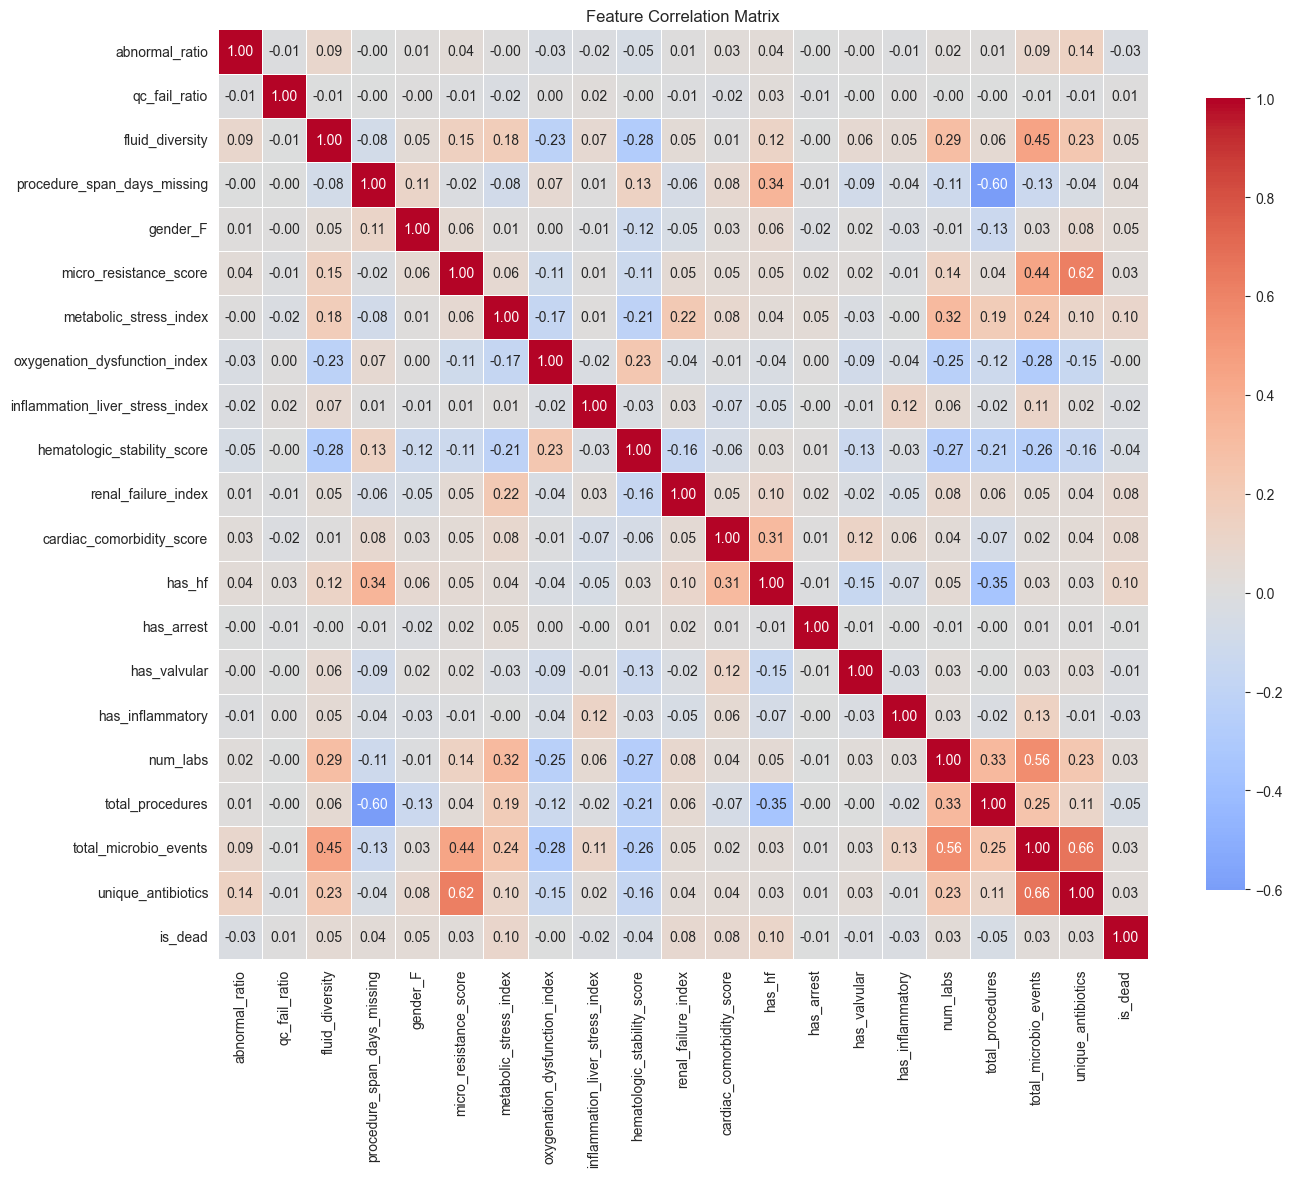

In [11]:
# Check for highly correlated features
correlation_matrix = X_processed.corr()
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:  # Threshold for high correlation
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("Highly correlated feature pairs (|correlation| > 0.9):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("No highly correlated feature pairs found (threshold: 0.9)")

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [12]:
# Remove highly correlated features (keep one from each pair)
# We'll keep the first feature and remove the second
features_to_remove = set()
for feat1, feat2, corr in high_corr_pairs:
    if feat2 not in features_to_remove:
        features_to_remove.add(feat2)
        print(f"Removing {feat2} (highly correlated with {feat1}: {corr:.3f})")

if features_to_remove:
    X_processed = X_processed.drop(columns=list(features_to_remove))
    print(f"\nAfter removing correlated features: {X_processed.shape}")
else:
    print("No features removed due to correlation")

No features removed due to correlation


## 5. Train-Test Split and Handle Class Imbalance

In [13]:
# Split into train and test sets (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# Check class imbalance
class_counts_train = y_train.value_counts()
imbalance_ratio = class_counts_train[0] / class_counts_train[1]
print(f"\nClass imbalance ratio (Class 0 / Class 1): {imbalance_ratio:.2f}")

# CRITICAL: Verify no data leakage between train and test sets
# Since we deduplicated to one row per subject, we need to ensure subjects don't appear in both sets
print(f"\n{'='*60}")
print("Checking for data leakage between train and test sets...")
print(f"{'='*60}")

# Get identifiers for train and test sets
# Note: X_train and X_test are DataFrames with index from df_classification_unique
train_subject_ids = set(df_classification_unique.iloc[X_train.index]['subject_id'])
test_subject_ids = set(df_classification_unique.iloc[X_test.index]['subject_id'])
train_alex_dom_ids = set(df_classification_unique.iloc[X_train.index]['alex_dom_id'])
test_alex_dom_ids = set(df_classification_unique.iloc[X_test.index]['alex_dom_id'])

# Check subject_id overlap (since labels are at subject level)
subject_overlap = train_subject_ids & test_subject_ids
# Check alex_dom_id overlap (admission-level check)
admission_overlap = train_alex_dom_ids & test_alex_dom_ids

if len(subject_overlap) > 0:
    print(f"\n⚠️  WARNING: {len(subject_overlap)} subjects appear in both train and test sets!")
    print("This will cause data leakage and overly optimistic performance metrics!")
    print(f"\nSample overlapping subjects: {list(subject_overlap)[:10]}")
elif len(admission_overlap) > 0:
    print(f"\n⚠️  WARNING: {len(admission_overlap)} admissions (alex_dom_id) appear in both sets!")
    print("This should not happen after deduplication.")
else:
    print(f"\n✓ No data leakage detected!")
    print(f"  Training set: {len(train_subject_ids)} unique subjects, {len(train_alex_dom_ids)} unique admissions")
    print(f"  Test set: {len(test_subject_ids)} unique subjects, {len(test_alex_dom_ids)} unique admissions")
    print(f"  Subject overlap: {len(subject_overlap)} subjects")
    print(f"  Admission overlap: {len(admission_overlap)} admissions")
    print("  Train/test split is clean - no data leakage!")
print(f"{'='*60}")

Training set: 3513 samples
Test set: 879 samples

Training set class distribution:
label_ischemic
0    1899
1    1614
Name: count, dtype: int64

Test set class distribution:
label_ischemic
0    475
1    404
Name: count, dtype: int64

Class imbalance ratio (Class 0 / Class 1): 1.18

Checking for data leakage between train and test sets...

✓ No data leakage detected!
  Training set: 3513 unique subjects, 3513 unique admissions
  Test set: 879 unique subjects, 879 unique admissions
  Subject overlap: 0 subjects
  Admission overlap: 0 admissions
  Train/test split is clean - no data leakage!


In [ ]:
# Standardize features (important for logistic regression and distance-based methods)
# Check if X_train_scaled exists, if not, create it
if 'X_train_scaled' not in globals():
    print("Standardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        
    print("Features standardized successfully!")
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Test set shape: {X_test_scaled.shape}")

# Set final training sets
X_train_final = X_train
y_train_final = y_train
X_train_final_scaled = X_train_scaled

Standardizing features...
Features standardized successfully!
Training set shape: (3513, 21)
Test set shape: (879, 21)


In [15]:
# Standardize features (important for logistic regression and distance-based methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features standardized successfully!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Features standardized successfully!
Training set shape: (3513, 21)
Test set shape: (879, 21)


## 6. Train Classification Models

We will train and compare the following models:
1. **Logistic Regression** - Linear model, interpretable
2. **K-Nearest Neighbors (KNN)** - Instance-based, distance-based classification
3. **Support Vector Machine (SVM)** - Kernel-based, effective for non-linear boundaries
4. **Decision Tree** - Non-linear, interpretable
5. **Random Forest** - Ensemble of trees, robust
6. **Gradient Boosting** - Advanced ensemble method

In [16]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "Support Vector Machine": SVC(random_state=42, class_weight='balanced', probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=10),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=5)
}

# Train models and store results
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # Use scaled features for distance-based models (Logistic Regression, KNN, SVM), original for tree-based models
    if name in ["Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"]:
        model.fit(X_train_final_scaled, y_train_final)
        y_train_pred = model.predict(X_train_final_scaled)
        y_test_pred = model.predict(X_test_scaled)
        y_train_proba = model.predict_proba(X_train_final_scaled)[:, 1]
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For tree-based models, use original (non-scaled) features
        model.fit(X_train_final, y_train_final)
        y_train_pred = model.predict(X_train_final)
        y_train_proba = model.predict_proba(X_train_final)[:, 1]
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_metrics = {
        "accuracy": accuracy_score(y_train_final, y_train_pred),
        "balanced_accuracy": balanced_accuracy_score(y_train_final, y_train_pred),
        "precision": precision_score(y_train_final, y_train_pred, zero_division=0),
        "recall": recall_score(y_train_final, y_train_pred),
        "f1": f1_score(y_train_final, y_train_pred),
        "roc_auc": roc_auc_score(y_train_final, y_train_proba)
    }
    
    test_metrics = {
        "accuracy": accuracy_score(y_test, y_test_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "roc_auc": roc_auc_score(y_test, y_test_proba)
    }
    
    results[name] = {
        "train": train_metrics,
        "test": test_metrics,
        "y_test_pred": y_test_pred,
        "y_test_proba": y_test_proba,
        "y_train_pred": y_train_pred,
        "y_train_proba": y_train_proba
    }
    
    trained_models[name] = model
    
    print(f"\nTraining Metrics:")
    for metric, value in train_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    print(f"\nTest Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

print(f"\n{'='*60}")
print("All models trained successfully!")
print(f"{'='*60}")


Training Logistic Regression...

Training Metrics:
  accuracy: 0.8383
  balanced_accuracy: 0.8428
  precision: 0.7821
  recall: 0.8984
  f1: 0.8362
  roc_auc: 0.9210

Test Metrics:
  accuracy: 0.8407
  balanced_accuracy: 0.8463
  precision: 0.7773
  recall: 0.9158
  f1: 0.8409
  roc_auc: 0.9201

Training K-Nearest Neighbors...

Training Metrics:
  accuracy: 1.0000
  balanced_accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  roc_auc: 1.0000

Test Metrics:
  accuracy: 0.8350
  balanced_accuracy: 0.8357
  precision: 0.8061
  recall: 0.8441
  f1: 0.8247
  roc_auc: 0.8943

Training Support Vector Machine...

Training Metrics:
  accuracy: 0.8631
  balanced_accuracy: 0.8678
  precision: 0.8054
  recall: 0.9257
  f1: 0.8613
  roc_auc: 0.9363

Test Metrics:
  accuracy: 0.8430
  balanced_accuracy: 0.8477
  precision: 0.7854
  recall: 0.9059
  f1: 0.8414
  roc_auc: 0.9101

Training Decision Tree...

Training Metrics:
  accuracy: 0.8984
  balanced_accuracy: 0.9007
  precision: 

## 7. Model Comparison and Evaluation

In [17]:
# Create comparison DataFrame
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        "Model": name,
        "Train Accuracy": result["train"]["accuracy"],
        "Test Accuracy": result["test"]["accuracy"],
        "Train Balanced Accuracy": result["train"]["balanced_accuracy"],
        "Test Balanced Accuracy": result["test"]["balanced_accuracy"],
        "Train Precision": result["train"]["precision"],
        "Test Precision": result["test"]["precision"],
        "Train Recall": result["train"]["recall"],
        "Test Recall": result["test"]["recall"],
        "Train F1": result["train"]["f1"],
        "Test F1": result["test"]["f1"],
        "Train ROC-AUC": result["train"]["roc_auc"],
        "Test ROC-AUC": result["test"]["roc_auc"]
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("Model Comparison - All Metrics")
print("="*80)
display(comparison_df)

Model Comparison - All Metrics


,Model,Train Accuracy,Test Accuracy,Train Balanced Accuracy,Test Balanced Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression,0.8383,0.8407,0.8428,0.8463,0.7821,0.7773,0.8984,0.9158,0.8362,0.8409,0.9210,0.9201
1,K-Nearest Neighbors,1.0000,0.8350,1.0000,0.8357,1.0000,0.8061,1.0000,0.8441,1.0000,0.8247,1.0000,0.8943
2,Support Vector Machine,0.8631,0.8430,0.8678,0.8477,0.8054,0.7854,0.9257,0.9059,0.8613,0.8414,0.9363,0.9101
3,Decision Tree,0.8984,0.8168,0.9007,0.8198,0.8610,0.7706,0.9287,0.8564,0.8936,0.8113,0.9653,0.8846
4,Random Forest,0.9112,0.8464,0.9149,0.8509,0.8617,0.7905,0.9610,0.9059,0.9086,0.8443,0.9812,0.9237
5,Gradient Boosting,0.9305,0.8578,0.9314,0.8603,0.9097,0.8163,0.9424,0.8911,0.9257,0.8521,0.9825,0.9300


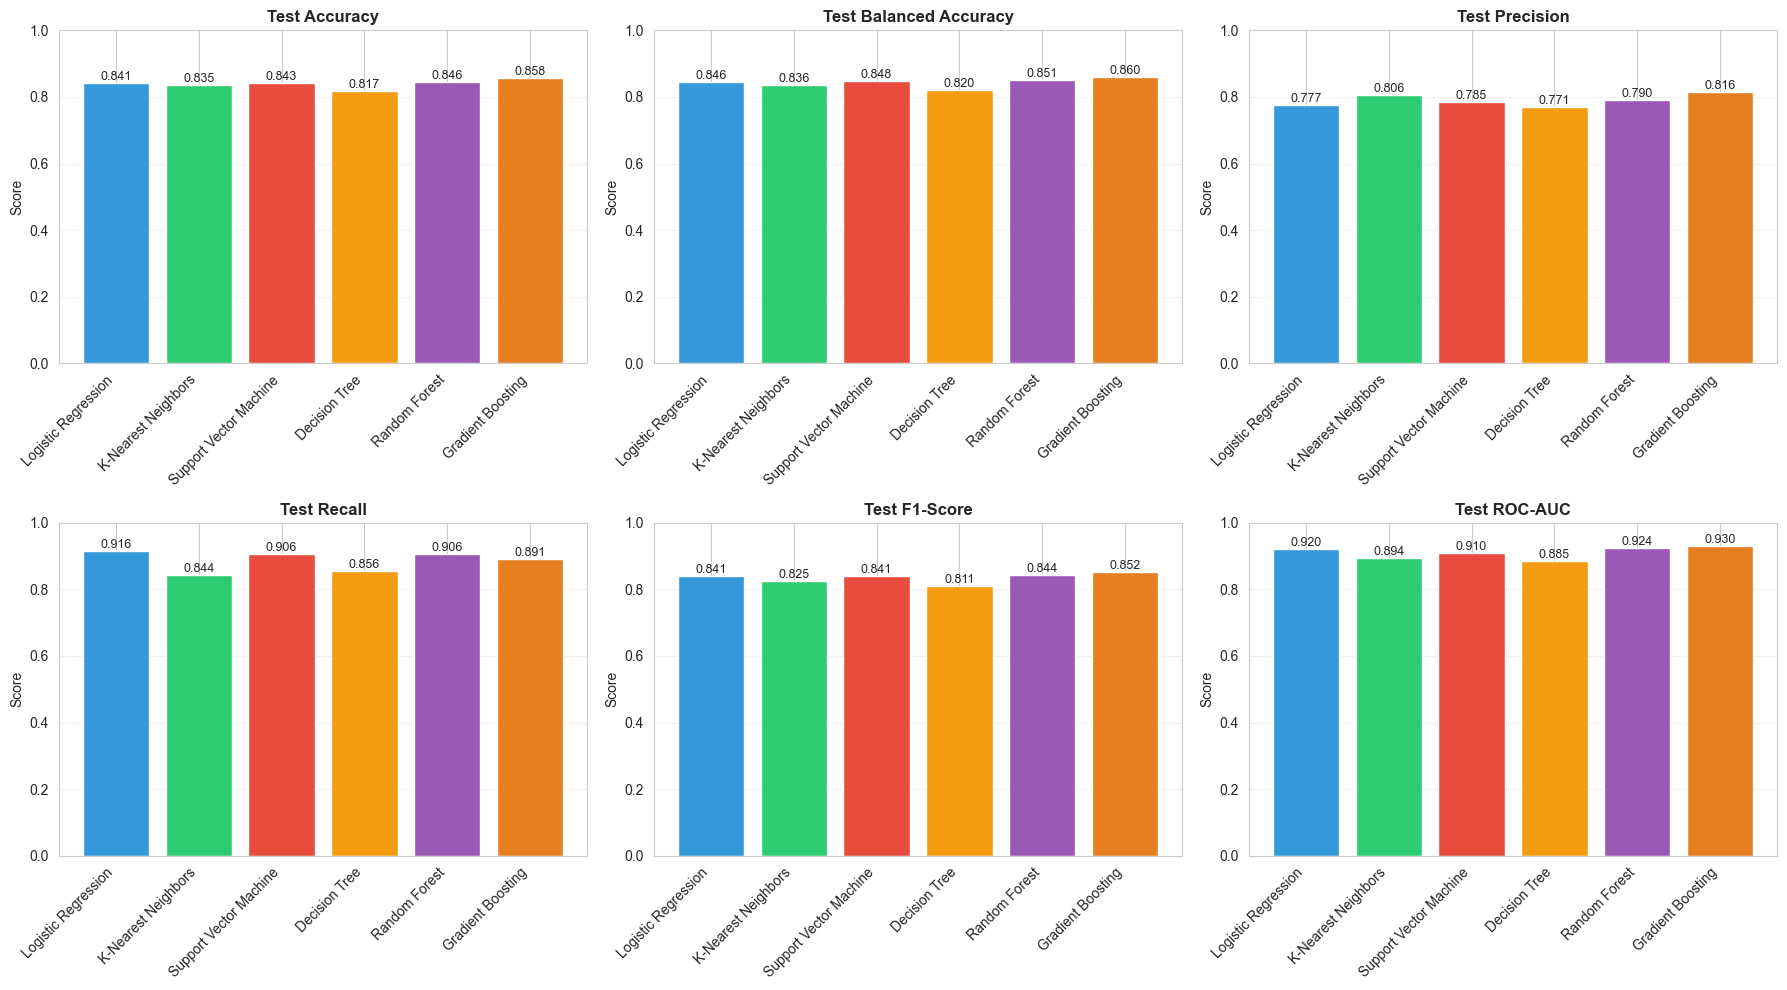

In [18]:
# Visualize comparison of key metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = [
    ("Test Accuracy", "accuracy"),
    ("Test Balanced Accuracy", "balanced_accuracy"),
    ("Test Precision", "precision"),
    ("Test Recall", "recall"),
    ("Test F1-Score", "f1"),
    ("Test ROC-AUC", "roc_auc")
]

for idx, (title, metric_key) in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = [results[name]["test"][metric_key] for name in models.keys()]
    bars = ax.bar(models.keys(), values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#e67e22'])
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel("Score", fontsize=10)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "4_metrics_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

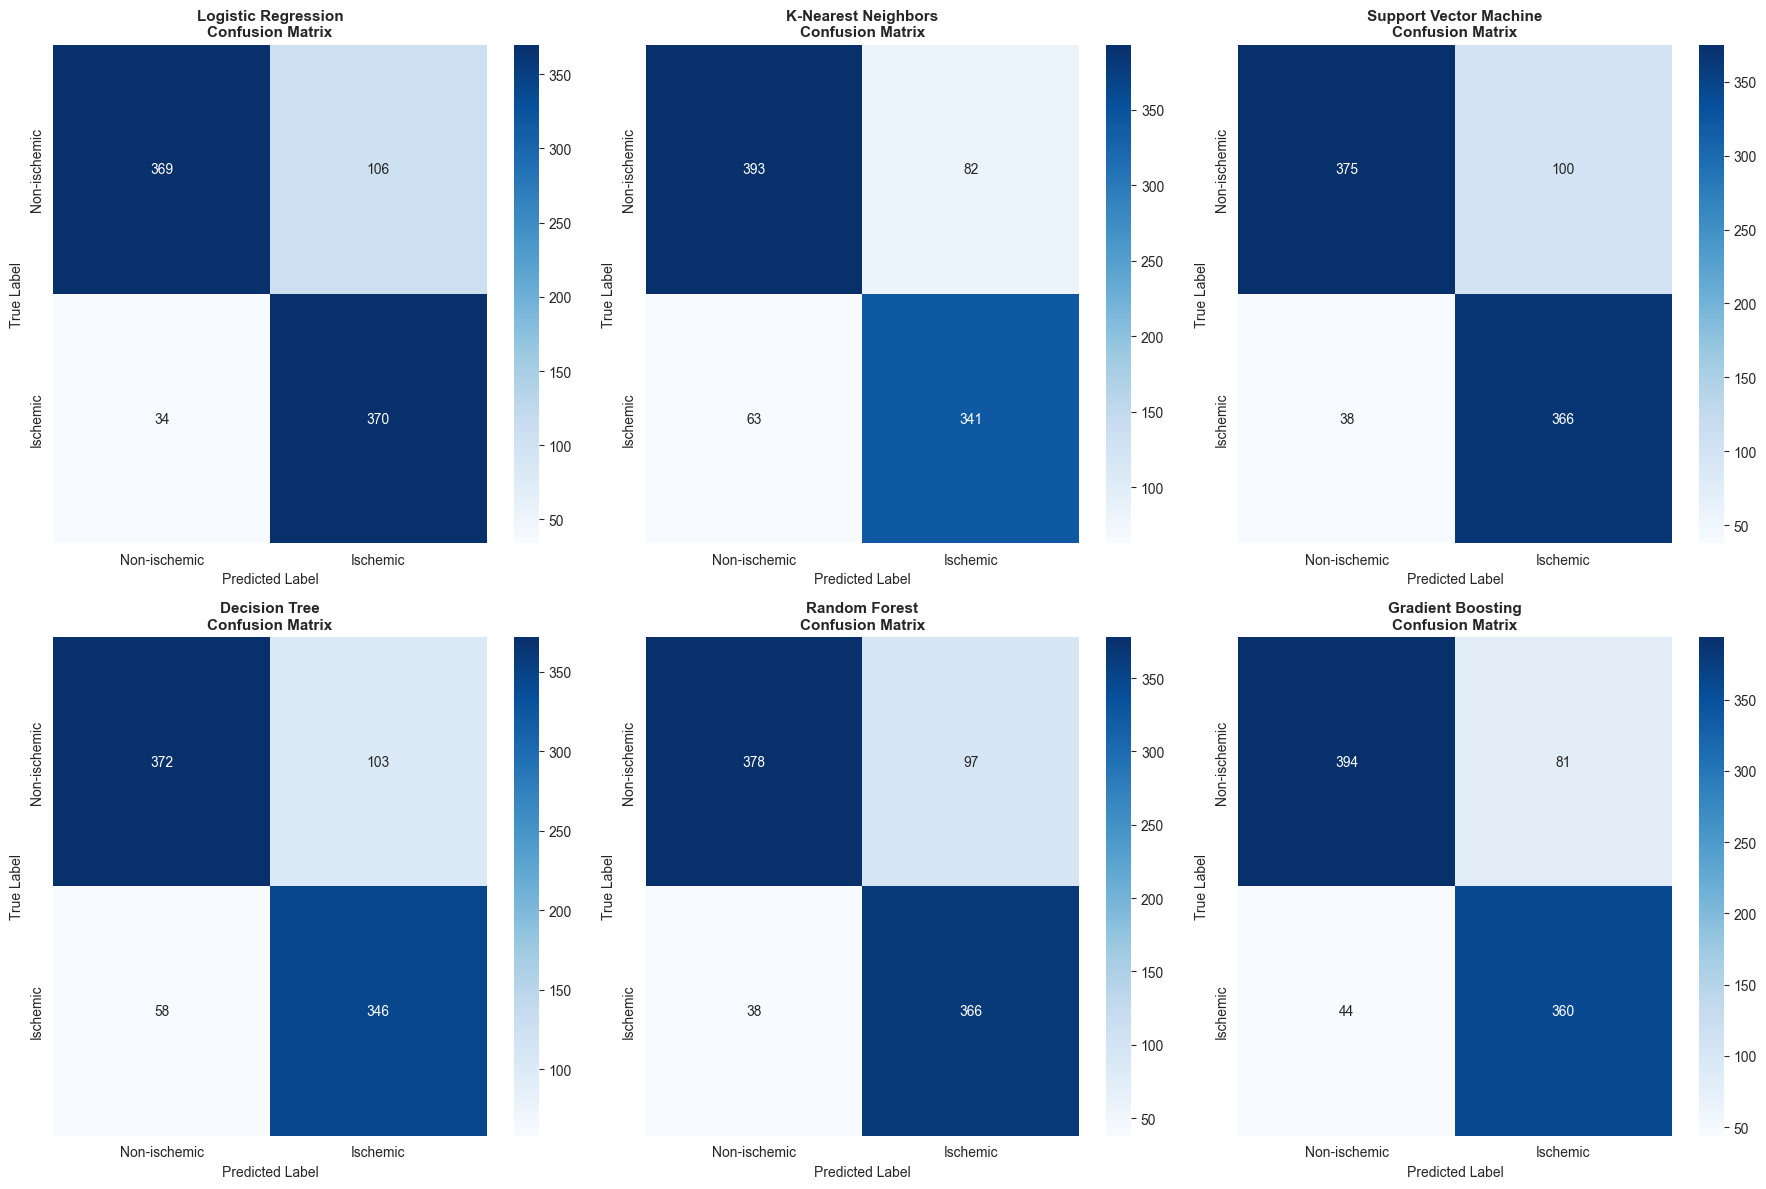

In [19]:
# Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Only show the first 6 models (in case there are more)
for idx, (name, result) in enumerate(list(results.items())[:6]):

    ax = axes[idx]
    cm = confusion_matrix(y_test, result["y_test_pred"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-ischemic', 'Ischemic'],
                yticklabels=['Non-ischemic', 'Ischemic'])
    ax.set_title(f"{name}\nConfusion Matrix", fontsize=11, fontweight='bold')
    ax.set_ylabel("True Label", fontsize=10)
    ax.set_xlabel("Predicted Label", fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "4_confusion_matrices.png"), dpi=300, bbox_inches='tight')
plt.show()

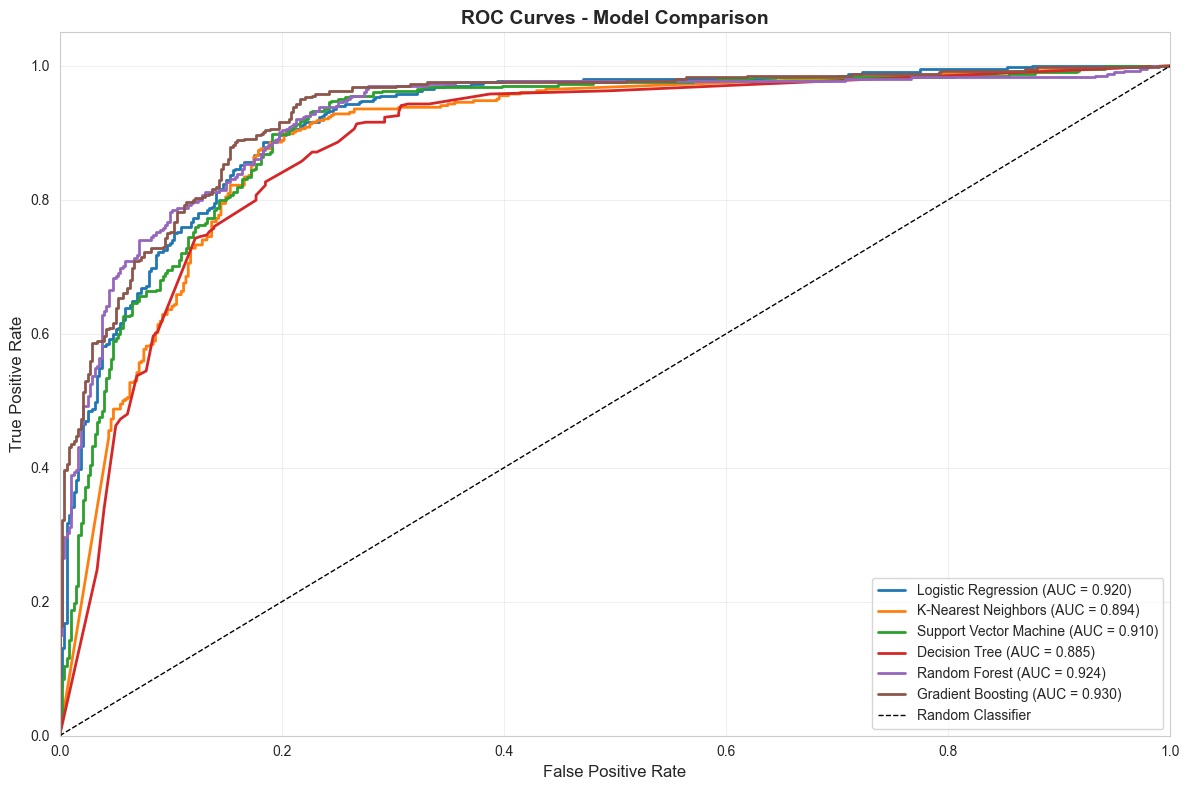

In [20]:
# ROC Curves
plt.figure(figsize=(12, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result["y_test_proba"])
    auc = result["test"]["roc_auc"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "4_roc_curves.png"), dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Detailed classification reports
for name, result in results.items():
    print(f"\n{'='*60}")
    print(f"Classification Report: {name}")
    print(f"{'='*60}")
    print(classification_report(y_test, result["y_test_pred"], 
                                target_names=['Non-ischemic', 'Ischemic']))


Classification Report: Logistic Regression
              precision    recall  f1-score   support

Non-ischemic       0.92      0.78      0.84       475
    Ischemic       0.78      0.92      0.84       404

    accuracy                           0.84       879
   macro avg       0.85      0.85      0.84       879
weighted avg       0.85      0.84      0.84       879


Classification Report: K-Nearest Neighbors
              precision    recall  f1-score   support

Non-ischemic       0.86      0.83      0.84       475
    Ischemic       0.81      0.84      0.82       404

    accuracy                           0.84       879
   macro avg       0.83      0.84      0.83       879
weighted avg       0.84      0.84      0.84       879


Classification Report: Support Vector Machine
              precision    recall  f1-score   support

Non-ischemic       0.91      0.79      0.84       475
    Ischemic       0.79      0.91      0.84       404

    accuracy                           0.84    

## 8. Feature Importance Analysis

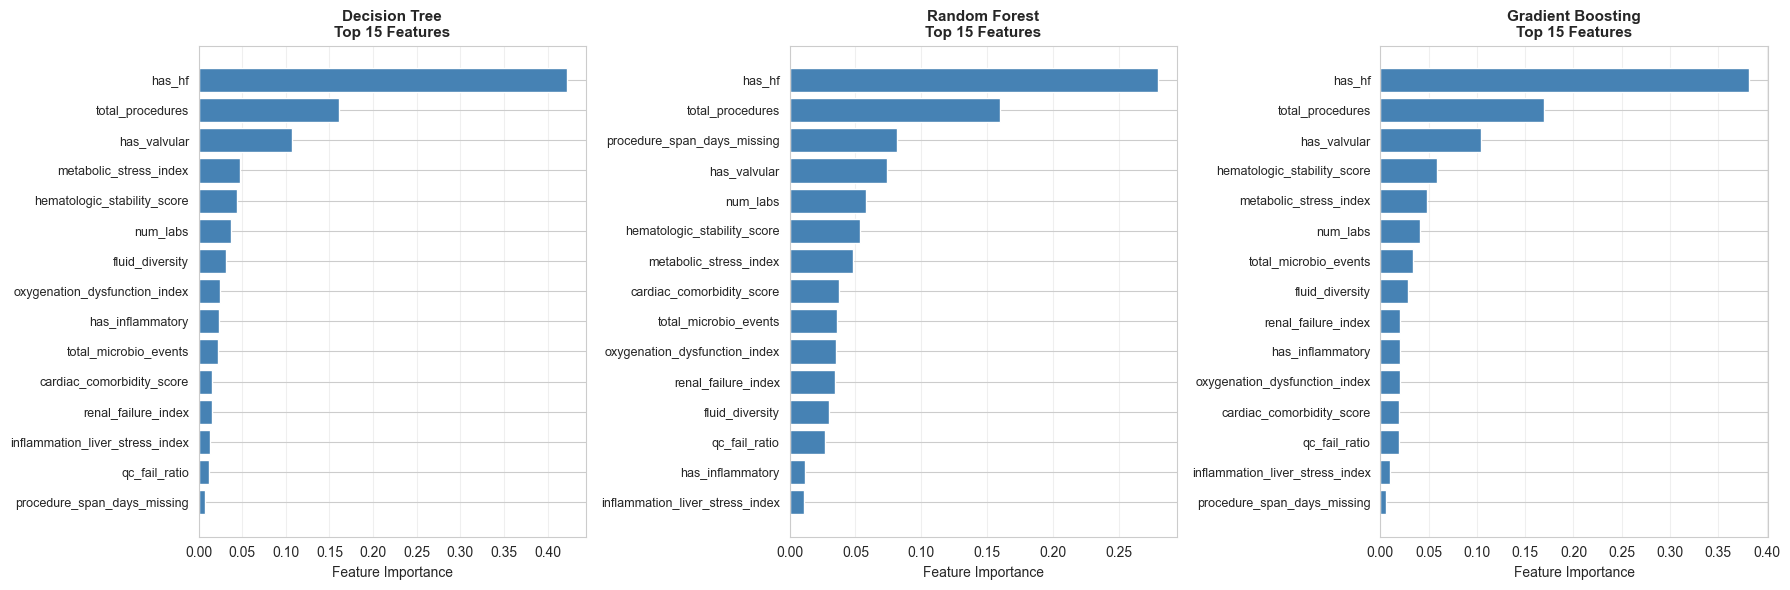

In [22]:
# Feature importance for tree-based models
tree_models = ["Decision Tree", "Random Forest", "Gradient Boosting"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, name in enumerate(tree_models):
    if name in trained_models:
        model = trained_models[name]
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_names = X_train.columns
            
            # Sort by importance
            indices = np.argsort(importances)[::-1]
            top_n = min(15, len(feature_names))  # Show top 15 features
            
            ax = axes[idx]
            ax.barh(range(top_n), importances[indices[:top_n]], color='steelblue')
            ax.set_yticks(range(top_n))
            ax.set_yticklabels([feature_names[i] for i in indices[:top_n]], fontsize=9)
            ax.set_xlabel('Feature Importance', fontsize=10)
            ax.set_title(f'{name}\nTop {top_n} Features', fontsize=11, fontweight='bold')
            ax.invert_yaxis()
            ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "4_feature_importance_tree_models.png"), dpi=300, bbox_inches='tight')
plt.show()

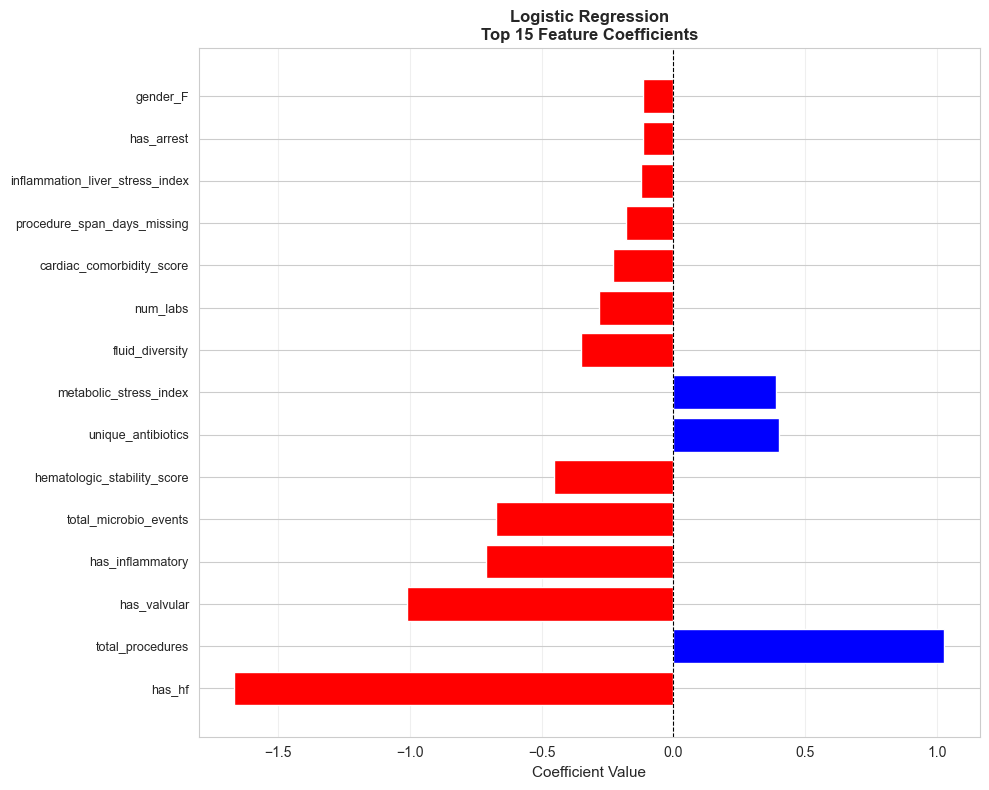

In [23]:
# Logistic Regression coefficients
if "Logistic Regression" in trained_models:
    lr_model = trained_models["Logistic Regression"]
    coefficients = lr_model.coef_[0]
    feature_names = X_train_scaled.columns
    
    # Sort by absolute coefficient value
    indices = np.argsort(np.abs(coefficients))[::-1]
    top_n = min(15, len(feature_names))
    
    plt.figure(figsize=(10, 8))
    colors = ['red' if c < 0 else 'blue' for c in coefficients[indices[:top_n]]]
    plt.barh(range(top_n), coefficients[indices[:top_n]], color=colors)
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]], fontsize=9)
    plt.xlabel('Coefficient Value', fontsize=11)
    plt.title(f'Logistic Regression\nTop {top_n} Feature Coefficients', fontsize=12, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "4_feature_importance_logistic_regression.png"), dpi=300, bbox_inches='tight')
    plt.show()

## 9. Cross-Validation Analysis

## 10. Threshold Optimization

Based on imbalanced learning techniques, we can optimize the decision threshold to improve performance metrics (especially recall for the minority class).

In [24]:
# Optimize threshold for each model to maximize F1-score
from sklearn.metrics import f1_score

optimal_thresholds = {}
optimized_results = {}

print("Threshold Optimization")
print("="*60)

for name, result in results.items():
    y_test_proba = result["y_test_proba"]
    
    # Try different thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_thresh = (y_test_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    optimal_thresholds[name] = best_threshold
    
    # Evaluate with optimal threshold
    y_test_pred_opt = (y_test_proba >= best_threshold).astype(int)
    
    optimized_results[name] = {
        "threshold": best_threshold,
        "accuracy": accuracy_score(y_test, y_test_pred_opt),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_test_pred_opt),
        "precision": precision_score(y_test, y_test_pred_opt, zero_division=0),
        "recall": recall_score(y_test, y_test_pred_opt),
        "f1": f1_score(y_test, y_test_pred_opt)
    }
    
    print(f"\n{name}:")
    print(f"  Optimal threshold: {best_threshold:.3f}")
    print(f"  F1-score improvement: {optimized_results[name]['f1']:.4f} (vs {result['test']['f1']:.4f} at 0.5)")
    print(f"  Recall: {optimized_results[name]['recall']:.4f} (vs {result['test']['recall']:.4f} at 0.5)")

print(f"\n{'='*60}")

Threshold Optimization

Logistic Regression:
  Optimal threshold: 0.450
  F1-score improvement: 0.8415 (vs 0.8409 at 0.5)
  Recall: 0.9332 (vs 0.9158 at 0.5)

K-Nearest Neighbors:
  Optimal threshold: 0.400
  F1-score improvement: 0.8399 (vs 0.8247 at 0.5)
  Recall: 0.8960 (vs 0.8441 at 0.5)

Support Vector Machine:
  Optimal threshold: 0.250
  F1-score improvement: 0.8472 (vs 0.8414 at 0.5)
  Recall: 0.9332 (vs 0.9059 at 0.5)



Decision Tree:
  Optimal threshold: 0.300
  F1-score improvement: 0.8200 (vs 0.8113 at 0.5)
  Recall: 0.9134 (vs 0.8564 at 0.5)

Random Forest:
  Optimal threshold: 0.450
  F1-score improvement: 0.8471 (vs 0.8443 at 0.5)
  Recall: 0.9257 (vs 0.9059 at 0.5)

Gradient Boosting:
  Optimal threshold: 0.350
  F1-score improvement: 0.8603 (vs 0.8521 at 0.5)
  Recall: 0.9530 (vs 0.8911 at 0.5)



## 11. Summary and Discussion

In [25]:
# Perform cross-validation for more robust evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("Performing 5-fold cross-validation...")
print("="*60)

for name, model in models.items():
    print(f"\n{name}:")
    
    # Use appropriate features (scaled for distance-based models)
    if name in ["Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"]:
        X_cv = X_train_scaled
        y_cv = y_train
    else:
        # For tree-based models, use original (non-scaled) features
        X_cv = X_train
        y_cv = y_train
    
    # Cross-validation scores
    cv_scores_accuracy = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='accuracy')
    cv_scores_balanced = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='balanced_accuracy')
    cv_scores_f1 = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='f1')
    cv_scores_roc_auc = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='roc_auc')
    
    cv_results[name] = {
        "accuracy": cv_scores_accuracy,
        "balanced_accuracy": cv_scores_balanced,
        "f1": cv_scores_f1,
        "roc_auc": cv_scores_roc_auc
    }
    
    print(f"  Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
    print(f"  Balanced Accuracy: {cv_scores_balanced.mean():.4f} (+/- {cv_scores_balanced.std() * 2:.4f})")
    print(f"  F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
    print(f"  ROC-AUC: {cv_scores_roc_auc.mean():.4f} (+/- {cv_scores_roc_auc.std() * 2:.4f})")

print(f"\n{'='*60}")

Performing 5-fold cross-validation...

Logistic Regression:
  Accuracy: 0.8358 (+/- 0.0281)
  Balanced Accuracy: 0.8403 (+/- 0.0273)
  F1-Score: 0.8339 (+/- 0.0260)
  ROC-AUC: 0.9180 (+/- 0.0133)

K-Nearest Neighbors:
  Accuracy: 0.8264 (+/- 0.0278)
  Balanced Accuracy: 0.8273 (+/- 0.0289)
  F1-Score: 0.8161 (+/- 0.0316)
  ROC-AUC: 0.8956 (+/- 0.0128)

Support Vector Machine:
  Accuracy: 0.8389 (+/- 0.0185)
  Balanced Accuracy: 0.8429 (+/- 0.0169)
  F1-Score: 0.8359 (+/- 0.0156)
  ROC-AUC: 0.9162 (+/- 0.0110)

Decision Tree:
  Accuracy: 0.8266 (+/- 0.0195)
  Balanced Accuracy: 0.8278 (+/- 0.0207)
  F1-Score: 0.8169 (+/- 0.0237)
  ROC-AUC: 0.8720 (+/- 0.0320)

Random Forest:
  Accuracy: 0.8497 (+/- 0.0153)
  Balanced Accuracy: 0.8527 (+/- 0.0148)
  F1-Score: 0.8447 (+/- 0.0147)
  ROC-AUC: 0.9297 (+/- 0.0120)

Gradient Boosting:
  Accuracy: 0.8523 (+/- 0.0138)
  Balanced Accuracy: 0.8529 (+/- 0.0123)
  F1-Score: 0.8427 (+/- 0.0114)
  ROC-AUC: 0.9284 (+/- 0.0084)



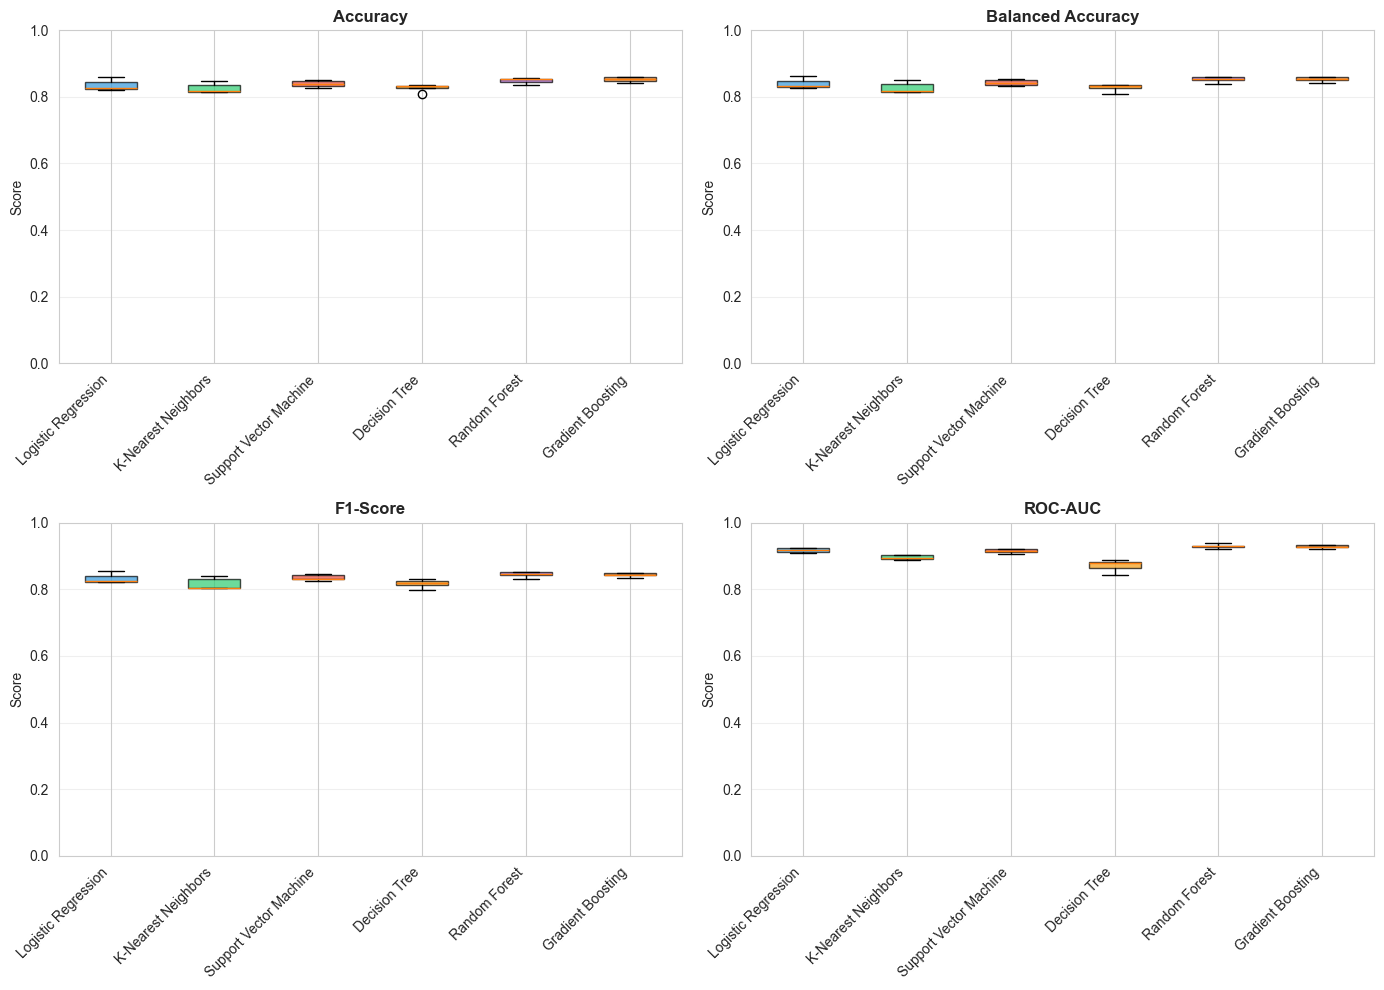

In [26]:
# Visualize cross-validation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics_cv = [
    ("Accuracy", "accuracy"),
    ("Balanced Accuracy", "balanced_accuracy"),
    ("F1-Score", "f1"),
    ("ROC-AUC", "roc_auc")
]

for idx, (title, metric_key) in enumerate(metrics_cv):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = [cv_results[name][metric_key] for name in models.keys()]
    
    bp = ax.boxplot(data_to_plot, labels=models.keys(), patch_artist=True)
    
    # Color the boxes (6 colors for 6 models)
    colors_box = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#e67e22']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel("Score", fontsize=10)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "4_cv_metrics_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()